In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import bootstrap
from numba import njit
from jitr import (
    ProjectileTargetSystem,
    InteractionMatrix,
    RMatrixSolver,
    woods_saxon_potential,
    woods_saxon_prime,
    coulomb_charged_sphere,
)
import corner

## Set up model
We would like to calibrate the East Lansing model. The East Lansing Model (ELM) is defined in the standard way:

\begin{align}
    U(r,E,A) &= 
    -\bigg( V(E) + i W(E)  \bigg) f(r,R,a)  - 4 i a W_D(E) \frac{d}{dr} f(r,R,a) \\
    & + \bigg( V_{so}(E) + i W_{so}(E)  \bigg)  \bigg( \frac{\hbar}{m_\pi c}\bigg)^2 \frac{1}{r} \frac{d}{dr}  f(r,R,a)  + V_C(r).
\end{align}

Here, $V_C$ is the standard Coulomb charged sphere form (see \cite{koning2003local} Eq. 4), and $f(r,R,a)$ is the Woods-Saxon form factor. Note that all terms shared the same geometry. The radius of the potential $R$ and the diffuseness are parameterized as without any $A$ dependence aside from the typical volume term. The free parameters $r_0$, $r_A$ and $a$ are in units of fm.

\begin{align}
    R &= r_0 + r_A A^{1/3} \\
    a &= a_0.
\end{align}

The depths of each term have an isoscalar and isovector component which share energy dependencies. They are parameterized as a function of $E- E_F$, the difference between the center-of-mass frame energy between the projectile and target, and the Fermi energy of the target, the latter of which is not treated as a free parameter but is instead taken from experiment. The depths terms are

\begin{align}
    V(E) &= V \big( 1 +  \frac{T_z}{2 A}  \eta_V \big) \big( 1 + \alpha (E - E_f) + \beta (E- E_F)^2 \big) \\
    W(E) &= W \big( 1 +  \frac{T_z}{2 A}  \eta_W \big) \frac{(E - E_f)^2}{(E-E_F)^2 + \gamma_W^2} \\
    W_D(E) &= W_D \big( 1 +  \frac{T_z}{2 A}  \eta_D  \big) \frac{(E - E_f)^2}{(E-E_F)^2 + \gamma_D^2} \\
    V_{so}(E) &= V_{so} \big(1  +  \frac{T_z}{2 A} \eta_{so}  \big)  \\
    W_{so}(E) &= W_{so} \big(1  +  \frac{T_z}{2 A} \eta_{so} \big) \frac{(E - E_f)^2}{(E-E_F)^2 + \gamma_{so}^2}.
\end{align}

Each depth $i$ is parameterized with a ratio between the isovector and isoscalar strengths, $\eta_i$. Note the neglect of any $A$ dependence of the depths aside from the isovector factors. This was chosen due to recent uncertainty quantified calibration of global optical potentials to elastic scattering observables indicating that the correction terms linear in $A$ typically are at least an order of magnitude smaller than corresponding $A$ independent terms, and have uncertainties on the order of their magnitudes. Also note that the spin-orbit terms share a common ratio between isovector and isoscalar strengths, $\eta_{so}$.

In total, the depths have 14 free parameters; 5 magnitudes $V$, $W$, $W_D$, $V_{so}$ and $W_{so}$, 4 isovector to isoscalar ratios $\eta_V$, $\eta_W$, $\eta_D$, $\eta_{so}$, 2 terms for the polynomial energy dependence of $V(E)$; $\alpha$ and $\beta$, and 3 terms for the energy dependence of the imaginary strengths; $\gamma_W$, $\gamma_D$ and $\gamma_{so}$. Including the 3 free geometric parameters, there are 17 free parameters total. 


In [2]:
class Parameter:
    def __init__(self, name, dtype, fancy_label=None, bounds=None, note=None):
        self.name = name
        self.dtype = dtype
        self.fancy_label = fancy_label if fancy_label is not None else name
        self.bounds = bounds
        self.note = note

In [3]:
elm_params = [
    Parameter("V", np.float64, r"$V$ [MeV]"),
    Parameter("W", np.float64, r"$W$ [MeV]"),
    Parameter("alpha", np.float64, r"$\alpha$"),
    Parameter("beta", np.float64, r"\beta"),
    Parameter("Wd", np.float64, r"$W_D$ [MeV]"),
    Parameter("Vso", np.float64, r"$V_{so}$ [MeV]"),
    Parameter("Wso", np.float64, r"$W_{so}$ [MeV]"),
    Parameter("gamma_w", np.float64, r"$\gamma_W$ [MeV]"),
    Parameter("gamma_d", np.float64, r"$\gamma_D$ [MeV]"),
    Parameter("gamma_so", np.float64, r"$\gamma_{SO}$ [MeV]"),
    Parameter("eta_v", np.float64, r"$\eta_V$ [MeV]"),
    Parameter("eta_w", np.float64, r"$\eta_W$ [MeV]"),
    Parameter("eta_d", np.float64, r"$\eta_D$ [MeV]"),
    Parameter("eta_so", np.float64, r"$\eta_{so}$ [MeV]"),
    Parameter("r0", np.float64, r"$r_0$ [fm]", bounds=[0, np.inf]),
    Parameter("rA", np.float64, r"$r_A$ [fm]", bounds=[0, np.inf]),
    Parameter("a", np.float64, r"$a$ [fm]", bounds=[0, np.inf]),
    Parameter("Ef", np.float64, r"$E_f$ [MeV]", note="Fermi energy"),
    Parameter("Z", np.float64, r"$Z$"),
    Parameter("A", np.int32, r"$A$"),
    Parameter("l", np.int32, r"$\ell$ [$\hbar$]"),
    Parameter("j", np.int32, r"$j$ [$\hbar$]"),
    Parameter("E", np.float64, r"$E$ [MeV]"),
]
elm_params_dtype = [(p.name, p.dtype) for p in elm_params]
elm_fancy_labels = dict([(p.name, p.fancy_label) for p in elm_params])

Only a subset of the actual model params are of interest in a statistical calibration. In this case, we ignore $E_f$, $Z$, $A$, $l$, $j$ and $E$ in the statistical calibration, as they are determined by the target, reaction and partial wave.

In [4]:
elm_statistical_params = elm_params[:-6]
elm_stat_params_dtype = [(p.name, p.dtype) for p in elm_statistical_params]
N_params = len(elm_statistical_params)
N_params

17

In [5]:
MASS_PION = np.sqrt(1 / 2)  # 2.0 per Thomspon&Nuñes below Eq. (4.3.10) 1/fm


def coulomb(r: np.array, p: np.array):
    r"""
    Coulomb charged sphere in vectorized and JIT-ed form
    Params:
        r (np.array) : a 1D array of radii in fm of dtype=float and of size Nr
        p (np.array): a 1D array of the parameters of dtype=elm_params_dtype and of size Np
    Returns:
        U(r;params): a 2D array of shape (Np,Nr), with rows describing the radial Coulomb
        potential and each column corresponding to a set of params in p
    """
    assert params.dtype == elm_params_dtype
    assert p.shape == (p.size,)

    # coulomb radius same as nuclear
    R = p["r_0"] + p["r_A"] * p["A"] ** (1.0 / 3.0)

    # generate r grid for each parameter
    r = np.tile(r, (p.size, 1))

    return coulomb_charged_sphere(r, p["Z"], R)


def elm_interaction(r: np.array, p: np.array):
    r"""
    Vectorized and JIT-ed implementation of the elm interaction. Default case
    Params:
        r (np.array) : a 1D array of radii in fm of dtype=float and of size Nr
        p (np.array): a 1D array of the parameters of dtype=elm_params_dtype and of size Np
    Returns:
        U(r;params): a 2D array of shape (Np,Nr), with rows describing the radial potential
            and each column corresponding to a set of params in p
    """

    # we can guard against bugs by making sure we are passing in the
    # correct parameter format. Note if we execute this python code with -O,
    # the assert statements will be eliminated
    assert params.dtype == elm_params_dtype
    assert p.shape == (p.size,)

    # generate r grid for each parameter
    r = np.tile(r, (p.size, 1))

    # spin orbit
    j = p["j"]
    l = p["l"]
    lds = j * (j + 1) - l * (l + 1) - 0.5 * (0.5 + 1)

    # geometry
    R = p["r0"] + p["rA"] * p["A"] ** (1.0 / 3.0)
    a = p["a"]

    # depths
    deltaE = p["E"] - p["Ef"]
    asym = (p["A"] - 2 * p["Z"]) / (2 * p["A"])
    V = (
        p["V"]
        * (1 + asym * p["eta_v"])
        * (1 + p["alpha"] * deltaE + p["beta"] * deltaE**2)
    )
    W = (
        p["W"]
        * (1 + asym * p["eta_w"])
        * deltaE**2
        / (deltaE**2 + p["gamma_w"] ** 2)
    )
    Wd = (
        p["Wd"]
        * (1 + asym * p["eta_d"])
        * deltaE**2
        / (deltaE**2 + p["gamma_d"] ** 2)
    )
    Vso = p["Vso"] * (1 + asym * p["eta_so"])
    Wso = (
        p["Wso"]
        * (1 + asym * p["eta_so"])
        * deltaE**2
        / (deltaE**2 + p["gamma_so"] ** 2)
    )

    central = woods_saxon_potential(
        r, V[:, np.newaxis], W[:, np.newaxis], R[:, np.newaxis], a[:, np.newaxis]
    )
    surf = (
        woods_saxon_prime(r, 0, Wd[:, np.newaxis], R[:, np.newaxis], a[:, np.newaxis])
        * 4
        * a[:, np.newaxis]
    )
    spin_orb = (
        (lds[:, np.newaxis] / MASS_PION**2)
        * woods_saxon_prime(
            r,
            Vso[:, np.newaxis],
            Wso[:, np.newaxis],
            R[:, np.newaxis],
            a[:, np.newaxis],
        )
        / r
    )

    return -central + surf + spin_orb

### visualize an ensemble of potential realizations
Let's demonstrate how to generate an ensemble of potentials according to an ensemble of parameters, and visualize the corresponding radial confidence intervals of the interaction

In [9]:
def sample_params(mu, cov, N):
    # sample
    X = np.random.multivariate_normal(mu, cov, N)
    # convert to our param type and sanitize negative radii and diffusenesses
    samples = np.array(
        [tuple(x) for x in X if np.all(x[-2:] > 0)], dtype=my_model_statistical_params
    )
    return samples

In [31]:
def generate_intervals(U, intervals=[0.95, 0.68], **kwargs):
    cis = {}
    for inter in intervals:
        cis[inter] = (
            bootstrap(
                (U.real,), np.mean, confidence_level=inter, **kwargs
            ).confidence_interval,
            bootstrap(
                (U.imag,), np.mean, confidence_level=inter, **kwargs
            ).confidence_interval,
        )
    return cis

In [34]:
r = np.linspace(0.01, 10, 1000)
# TODO replace below with a multivariate gaussian sample
# let's hand roll an ensemble of parameters for visualization purposes
params = np.zeros((100,), dtype=elm_params_dtype)
params["V"] = np.linspace(10, 50, 100)
params["W"] = np.linspace(2, 16, 100)
params["Wd"] = np.linspace(2, 16, 100)
# params["Vso"] = params["Wso"] = 4
params["r0"] = np.linspace(0.3, 4, 100)
params["rA"] = 1
params["a"] = np.linspace(0.1, 2, 100)
params["Ef"] = -16
params["E"] = 230
params["A"] = 12
params["Z"] = 6
U = elm_interaction(r, params)
print(U.shape)  # num params x num radial points

(100, 1000)


Let's use bootstrapping to generate a confidence interval so we can visualize this interaction as bands

In [32]:
cis = generate_intervals(U)

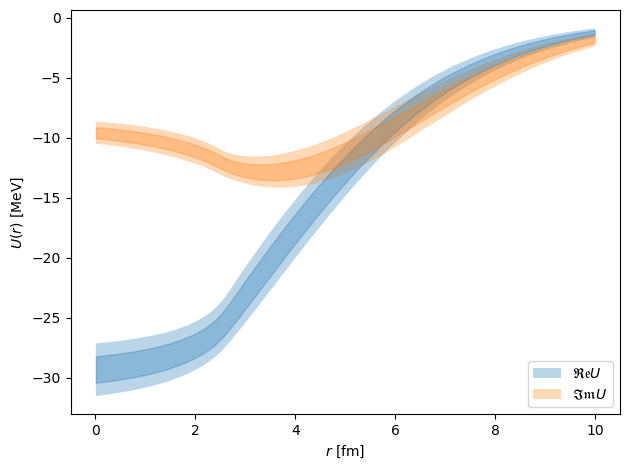

In [33]:
# plot 95% CI with light band and 68% CI with darker band
pr = plt.fill_between(
    r, cis[0.95][0].low, cis[0.95][0].high, label=r"$\mathfrak{Re} U$", alpha=0.3
)
pi = plt.fill_between(
    r, cis[0.95][1].low, cis[0.95][1].high, label=r"$\mathfrak{Im} U$", alpha=0.3
)
plt.fill_between(
    r, cis[0.68][0].low, cis[0.68][0].high, alpha=0.3, color=pr.get_facecolor()
)
plt.fill_between(
    r, cis[0.68][1].low, cis[0.68][1].high, alpha=0.3, color=pi.get_facecolor()
)

plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$U(r)$ [MeV]")
plt.legend(loc="lower right")
plt.tight_layout()

## Making a prior
let's assume our model prior can be described by a multivariate normal distribution of parameters and make up some mean and covariance that is consisten with Koning-Delaroche

In [10]:
# TODO fit parameters in ELM to KDUQ as prior
mu = np.array([40.2, 10.0, 5.1, 0.3, 3.6, 1.8])
cov = np.zeros((N_params, N_params))
cov += np.diag([10.1, 6.8, 3.1, 2.9, 3.1, 1.5]) ** 2

ValueError: operands could not be broadcast together with shapes (17,17) (6,6) (17,17) 

In [ ]:
samples = sample_params(mu, cov, 10000)

In [ ]:
# notice the shape is only the number of samples
samples.shape

In [ ]:
# looking at the first 3 samples, we see each one contains all 6 parameters
samples[:3]

### Visualize prior

In [ ]:
# we can take a look at just one parameter if we want
plt.hist(samples["V"])
plt.xlabel(my_model_fancy_labels["V"])

In [ ]:
fig = corner.corner(
    # to use corner, we need to view this array as a simple (num samples , num params) shaped array
    samples.view((np.float64, len(my_model_statistical_params))),
    labels=list(my_model_fancy_labels.values()),
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
fig.tight_layout()

## get data to calibrate to

Let's grab some data from Exfor. We will calibrate an energy dependent local optical potential.

### $d\sigma/d\Omega$
- [Mueller et al., 2011 $(n,n)$ at $11.9 \pm 0.207$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15364&subID=14303004&plus=1)
- [Hicks et al. 1988 $(n,n)$ at $7.97 \pm 0.22$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15369&subID=13507002&plus=1)
- [Feldman et al., 1994 $(p,p)$ at $201.4 \pm 0.2$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15371&subID=120154004&plus=1)
- [Alkhazov at al., 1972 $(p,p)$ at $1 \pm 0.01$ GeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15371&subID=150690011&plus=1)
- [McCamis et al., 1986 $(p,p)$ at multiple energies from 21 - 48 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=120624005&plus=1)

### $(\frac{d\sigma}{d\Omega})/(\frac{d\sigma_{Rutherford}}{s\Omega})$
- [Lombardi et al., 1972 $(p,p)$ at 14.03 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239018&plus=1)
- [Lombardi et al., 1972 $(p,p)$ at 15.05 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239016&plus=1)
- [Lombardi et al., 1972 $(p,p)$ at 15.63 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239014&plus=1)


### analyzing power $A_y$
- [Sakaguchi, 1983 $(p,p)$ at 65 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15371&subID=240032057&plus=1)
- [Sakaguchi, et al., 1979 $(p,p)$ at 65 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15371&subID=140166017&plus=1)
- [Noro et al., 1981 $(p,p)$ at 65 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15371&subID=140249009&plus=1)
- [Lombardi et al., 1972 $(p,p)$ at 14.03 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239019&plus=1)
- [Lombardi et al., 1972 $(p,p)$ at 15.05 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239017&plus=1)
- [Lombardi et al., 1972 $(p,p)$ at 15.63 MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=41089&subID=240239015&plus=1)

### quasi-elastic $(p,n)$


## Set up system

target (A,Z)

In [ ]:
Ca48 = (28, 20)
mass_Ca48 = 44657.26581995028  # MeV/c^2

projectile (A,z)

In [ ]:
proton = (1, 1)
mass_proton = 938.271653086152  # MeV/c^2

In [ ]:
neutron = (1, 0)
mass_neutron = 939.5654983938299  # MeV/c^2

## set up solver